# Cell population simulation: wild type has growth advantage over mutant

Summary of code:
1) Define cell object to record 

    - self index
    - index of parent
    - birth time
    - plasmid count at birth
    - steady state plasmid count
    - division time (dependent on existence of plasmids) <p>&nbsp;</p>
    
2) Simulate population starting with "keep" number of cells at time 0 with a nonzero number of plasmids and uniformly distributed ages

    - Calculate steady state plasmid number. **Assume that plasmid distribution reaches steady state before division**. 
        + If initial plasmid count is 0, steady state plasmid count is 0
        + If initial plasmid count > 0, steady state plasmid count is sampled from the distribution Binom([max plasmid number n], 0.5)
            *Question: This means that a cell can lose plasmids entirely - should I choose a different distribution? <p>&nbsp;</p>
        
    - Partition plasmids to two daughter cells.
        + Number of plasmids in daughter 1: sample from Binom([steady state plasmid number], 0.5)
        + Number of plasmids in daughter 2: [steady state plasmid number]-[daughter 1 plasmid number] <p>&nbsp;</p>
    
    - Create two new daughter cells.
        + Birth times are the current cell's division time
        + Division time is [birth time] + a_m if they have 0 plasmids, and [birth time] + a_w if they have more than 0 plasmids <p>&nbsp;</p>

    - Remove current cell from queue of cells to process; add daughter cells. Sort the queue by division time so that the next cell to divide is processed in the next loop <p>&nbsp;</p>

3) I store all cells that have already divided in a list called "cells", and I store all cells in the queue, aka the currently alive population, in a list called "Q". 
    



In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [2]:
class cell:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau

In [3]:
def simulation(Nmax, keep, a_w, a_m, n, p):
    
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    #c= cell(0,[],0,init_plasmid,a_w)   #cell(index,parent,birth,initialplasmid,tau)
    
    Q=[] # initialize queue of cells that have not divided yet (currently alive cells)
    for i in range(keep):
        Q.append(cell(i, [], 0, init_plasmid, np.random.uniform(0,a_w))) #cell(index,parent,birth,initialplasmid,tau)
        #note: division time = birth + tau. 
        #I initialize cells so they will divide at some point between 0 and a_w time units in the future
        #so for the initialized cells, their age at the begining of the simulation is a_w - Q[i].div
   
    cells=[] #list of cells that have divided already
    N=keep-1 #indices taken by initialized cell population

    while len(cells)<Nmax:
        #sort Q so Q[0] is next cell to divide
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
        
        #assign current cell to simulate
        current=Q[0]

        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            ss_plasmid_num=0
        else:
            ss_plasmid_num=np.random.binomial(n,p,size=None)
        current.ss_plasmid=ss_plasmid_num

        #Partition plasmids between two daughter cells
        d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
        d2_plasmids=ss_plasmid_num-d1_plasmids

        #Create two new daughter cells
        if d1_plasmids==0:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
        if d2_plasmids==0:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
    
        #Add current cell to vector 'cells'
        cells.extend([current])
    
        #####To keep cell population at a fixed number by removing one cell after each division
        ##### once the population reaches a certain size, include this section:
        #keep=1000
        if len(Q)>=keep:
            rem_cells = rand.sample(Q[1:],1)  #cells to be removed (does not include current or daughters)  
            new_Q = [x for x in Q if x not in rem_cells]
            Q = new_Q.copy()
        
        ########


        #Update index for next time
        N+=2

        #Update Q for next time - remove current cell, add daughter cells
        Q.remove(current)
        Q.extend([daughter1,daughter2])
        
    return Q, cells

In [4]:
Nmax=5000 #number of cells processed by simulation
keep=1000
a_w=1 #wild type mean lifetime (note: the population with the shorter lifetime has the advantage)
a_m=2 #0 plasmid mean lifetime
n=20 #max number of plasmids
p=.5 #probability of success in binomial distribution; used to calculate steady state plasmid num and also 
     #daughter plasmid partitioning


(array([  4.,  23.,  86., 123., 197., 192., 180., 103.,  52.,  30.,   6.,
          2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
        10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 20 artists>)

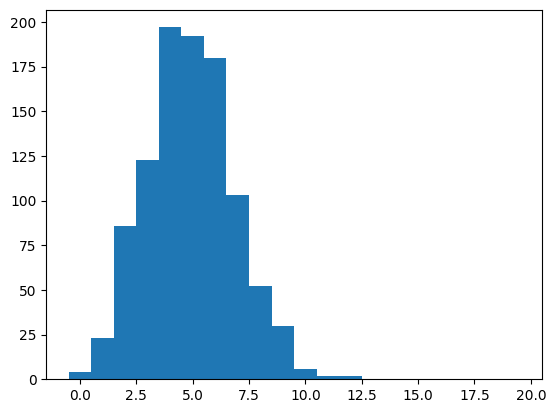

In [5]:
Q, cells = simulation(Nmax, keep, a_w, a_m, n, p)
Q_init=[]
for i in Q:
    Q_init.extend([i.init_plasmid])
plt.hist(Q_init,bins=n, range=[-.5,19.5])
